In [1]:
!pip install psutil --q
!pip install gsutil --q
!pip install gputil --q
! pip install torch torchvision psutil -q


In [5]:
import torch
import gc
import psutil
import GPUtil

def get_system_resources():
    """
    Get current system resource usage.
    """
    cpu_percent = psutil.cpu_percent()
    ram_percent = psutil.virtual_memory().percent
    
    gpu_info = []
    if torch.cuda.is_available():
        gpus = GPUtil.getGPUs()
        for gpu in gpus:
            gpu_info.append({
                'id': gpu.id,
                'memory_total': gpu.memoryTotal,
                'memory_used': gpu.memoryUsed,
                'memory_free': gpu.memoryFree,
                'memory_util': gpu.memoryUtil * 100
            })
    
    return {
        'cpu_percent': cpu_percent,
        'ram_percent': ram_percent,
        'gpu_info': gpu_info
    }

def print_system_resources(resources):
    """
    Print system resources in a readable format.
    """
    print(f"CPU Usage: {resources['cpu_percent']}%")
    print(f"RAM Usage: {resources['ram_percent']}%")
    for gpu in resources['gpu_info']:
        print(f"GPU {gpu['id']}:")
        print(f"  Total Memory: {gpu['memory_total']} MB")
        print(f"  Used Memory: {gpu['memory_used']} MB")
        print(f"  Free Memory: {gpu['memory_free']} MB")
        print(f"  Memory Utilization: {gpu['memory_util']:.2f}%")

def gpu_cleanup():
    """
    Perform a thorough GPU memory cleanup and report system resources before and after.
    """
    print("System resources before cleanup:")
    resources_before = get_system_resources()
    print_system_resources(resources_before)

    print("\nPerforming GPU memory cleanup...")
    
    # Clear PyTorch's CUDA cache
    torch.cuda.empty_cache()

    # Force garbage collection
    gc.collect()

    # Explicitly clear any remaining CUDA memory
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            with torch.cuda.device(f'cuda:{i}'):
                torch.cuda.empty_cache()
                torch.cuda.ipc_collect()

    print("\nSystem resources after cleanup:")
    resources_after = get_system_resources()
    print_system_resources(resources_after)

    print("\nGPU memory cleanup completed.")

    # Calculate and print the difference
    print("\nMemory freed:")
    for before, after in zip(resources_before['gpu_info'], resources_after['gpu_info']):
        memory_freed = before['memory_used'] - after['memory_used']
        print(f"GPU {before['id']}: {memory_freed} MB")

# Example usage:
if __name__ == "__main__":
    # Your training code here
    
    # After training or when you need to clean up
    gpu_cleanup()

System resources before cleanup:
CPU Usage: 2.3%
RAM Usage: 3.3%
GPU 0:
  Total Memory: 24564.0 MB
  Used Memory: 4.0 MB
  Free Memory: 24243.0 MB
  Memory Utilization: 0.02%
GPU 1:
  Total Memory: 24564.0 MB
  Used Memory: 4.0 MB
  Free Memory: 24243.0 MB
  Memory Utilization: 0.02%
GPU 2:
  Total Memory: 24564.0 MB
  Used Memory: 4.0 MB
  Free Memory: 24243.0 MB
  Memory Utilization: 0.02%

Performing GPU memory cleanup...

System resources after cleanup:
CPU Usage: 7.9%
RAM Usage: 4.1%
GPU 0:
  Total Memory: 24564.0 MB
  Used Memory: 4.0 MB
  Free Memory: 24243.0 MB
  Memory Utilization: 0.02%
GPU 1:
  Total Memory: 24564.0 MB
  Used Memory: 209.0 MB
  Free Memory: 24038.0 MB
  Memory Utilization: 0.85%
GPU 2:
  Total Memory: 24564.0 MB
  Used Memory: 209.0 MB
  Free Memory: 24038.0 MB
  Memory Utilization: 0.85%

GPU memory cleanup completed.

Memory freed:
GPU 0: 0.0 MB
GPU 1: -205.0 MB
GPU 2: -205.0 MB


In [16]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [3]:
!nvidia-smi

Tue Sep 17 09:58:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.113.01             Driver Version: 535.113.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               Off | 00000000:05:00.0 Off |                  Off |
| 30%   33C    P0              57W / 230W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
!nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


# Parallelism in AI Systems

In [9]:
!python distributed_training.py

Rank 2, Epoch 0, Batch 0/66, Loss: 0.0086
GPU 2 Memory: 12783.0MB / 24564.0MB
GPU 2 Utilization: 100.00%
CPU Usage: 54.5%, RAM Usage: 27.5%
Rank 1, Epoch 0, Batch 0/66, Loss: 0.0079
GPU 1 Memory: 12823.0MB / 24564.0MB
GPU 1 Utilization: 100.00%
CPU Usage: 54.7%, RAM Usage: 27.5%
Rank 0, Epoch 0, Batch 0/66, Loss: 0.0073
GPU 0 Memory: 12611.0MB / 24564.0MB
GPU 0 Utilization: 100.00%
CPU Usage: 54.4%, RAM Usage: 27.5%
Rank 0, Epoch 0, Batch 10/66, Loss: 0.0026
GPU 0 Memory: 13591.0MB / 24564.0MB
GPU 0 Utilization: 100.00%
CPU Usage: 26.5%, RAM Usage: 27.6%
Rank 1, Epoch 0, Batch 10/66, Loss: 0.0026
GPU 1 Memory: 13803.0MB / 24564.0MB
GPU 1 Utilization: 100.00%
CPU Usage: 26.5%, RAM Usage: 27.6%
Rank 2, Epoch 0, Batch 10/66, Loss: 0.0029
GPU 2 Memory: 13763.0MB / 24564.0MB
GPU 2 Utilization: 100.00%
CPU Usage: 26.5%, RAM Usage: 27.5%
Rank 0, Epoch 0, Batch 20/66, Loss: 0.0047
GPU 0 Memory: 13591.0MB / 24564.0MB
GPU 0 Utilization: 91.00%
CPU Usage: 26.7%, RAM Usage: 27.6%
Rank 2, Epoch 0, 

# Adaptive Thread BenchMark Execution

In [4]:
import time
from concurrent.futures import ThreadPoolExecutor
import numpy as np

def get_optimal_thread_count(cpu_cores, max_threads=36):
    """
    Determine the optimal thread count based on CPU cores.
    For I/O-bound operations, we can use more threads than cores.
    """
    return min(cpu_cores * 4, max_threads)

def run_threaded_operation(operation, items, num_threads):
    """
    Run an operation on items using specified number of threads.
    """
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        return list(executor.map(operation, items))

def benchmark_threading(operation, items, cpu_cores):
    """
    Benchmark the operation with different thread counts and return the optimal.
    """
    optimal_threads = get_optimal_thread_count(cpu_cores)
    
    print(f"CPU cores: {cpu_cores}")
    print(f"Estimated optimal threads: {optimal_threads}")
    
    # Single-threaded baseline
    start = time.time()
    single_result = [operation(item) for item in items]
    single_time = time.time() - start
    print(f"Single-threaded time: {single_time:.2f} seconds")
    
    best_time = single_time
    best_threads = 1
    
    # Test different thread counts
    for thread_count in [4, 8, 12, 16, 20, 24, 28, 32, 36]:
        if thread_count > optimal_threads:
            break
        
        start = time.time()
        multi_result = run_threaded_operation(operation, items, thread_count)
        multi_time = time.time() - start
        speedup = single_time / multi_time
        
        print(f"Threads: {thread_count}, Time: {multi_time:.2f} seconds, Speedup: {speedup:.2f}x")
        
        if multi_time < best_time:
            best_time = multi_time
            best_threads = thread_count
    
    print(f"\nOptimal thread count: {best_threads}")
    print(f"Best speedup: {single_time / best_time:.2f}x")
    
    return best_threads

# Example usage
if __name__ == "__main__":
    # Simulated I/O-bound operation
    def io_bound_operation(x):
        time.sleep(0.1)  # Simulate I/O operation
        return x * 2

    items = list(range(1000))  # 1000 items to process
    cpu_cores = 8  # Adjust this based on your system

    optimal_threads = benchmark_threading(io_bound_operation, items, cpu_cores)
    
    print("\nUsing optimal thread count for final run:")
    start = time.time()
    final_result = run_threaded_operation(io_bound_operation, items, optimal_threads)
    final_time = time.time() - start
    print(f"Final run time: {final_time:.2f} seconds")


CPU cores: 8
Estimated optimal threads: 32
Single-threaded time: 100.17 seconds
Threads: 4, Time: 25.06 seconds, Speedup: 4.00x
Threads: 8, Time: 12.53 seconds, Speedup: 7.99x
Threads: 12, Time: 8.42 seconds, Speedup: 11.90x
Threads: 16, Time: 6.32 seconds, Speedup: 15.85x
Threads: 20, Time: 5.02 seconds, Speedup: 19.96x
Threads: 24, Time: 4.21 seconds, Speedup: 23.77x
Threads: 28, Time: 3.62 seconds, Speedup: 27.70x
Threads: 32, Time: 3.21 seconds, Speedup: 31.18x

Optimal thread count: 32
Best speedup: 31.18x

Using optimal thread count for final run:
Final run time: 3.21 seconds


In [6]:
%pip install torch torchvision numpy pillow -q

Note: you may need to restart the kernel to use updated packages.


## Data Loading Implementation 

In [7]:
import time
from torchvision import datasets, transforms
import os

def load_and_process_image(index):
    """
    Simulates loading and processing an image from the dataset.

    Args:
        index (int): The index of the image in the dataset.

    Returns:
        numpy.ndarray: The processed image as a NumPy array.
    
    Note:
        This function includes a simulated delay to mimic the behavior of an
        I/O-bound operation (e.g., disk read, network download).
    """
    time.sleep(0.1)  # Simulate I/O operation delay for each image.
    image, _ = dataset[index]  # Fetch the image from the dataset at the specified index.
    return image.numpy()  # Convert the image tensor to a NumPy array for further processing.

# Define the image transformation pipeline
# The pipeline resizes each image to 224x224 and converts it to a tensor.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize each image to 224x224.
    transforms.ToTensor()  # Convert the image to a tensor for further processing in PyTorch.
])

# Load the CIFAR-10 dataset
# This dataset contains 60,000 32x32 color images in 10 classes, with 50,000 for training.
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Prepare items to process
items = list(range(1000))  # Process the first 1000 images from the dataset.

# Determine the number of CPU cores available for parallel processing
cpu_cores = os.cpu_count()  # Get the total number of CPU cores available on the machine.

# Benchmark optimal thread usage for data loading
# The `benchmark_threading` function should determine how many threads should be used 
# for optimal performance based on available CPU cores.
optimal_threads = benchmark_threading(load_and_process_image, items, cpu_cores)

# Run data loading with the determined optimal thread count
# This step executes `load_and_process_image` on the selected items using `optimal_threads`.
final_images = run_threaded_operation(load_and_process_image, items, optimal_threads)

# Output the number of images processed and the number of threads used
print(f"Loaded {len(final_images)} images using {optimal_threads} threads.")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:17<00:00, 9991559.06it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
CPU cores: 6
Estimated optimal threads: 24
Single-threaded time: 103.38 seconds
Threads: 4, Time: 26.35 seconds, Speedup: 3.92x
Threads: 8, Time: 14.00 seconds, Speedup: 7.38x
Threads: 12, Time: 10.39 seconds, Speedup: 9.95x
Threads: 16, Time: 7.69 seconds, Speedup: 13.45x
Threads: 20, Time: 6.07 seconds, Speedup: 17.02x
Threads: 24, Time: 5.35 seconds, Speedup: 19.32x

Optimal thread count: 24
Best speedup: 19.32x
Loaded 1000 images using 24 threads.


## Feature Extraction Implementation


In [8]:
import numpy as np
import os
import time

def extract_features(image_path):
    """
    Simulates the extraction of features from an image file.

    Args:
        image_path (str): The file path of the image from which features are to be extracted.

    Returns:
        np.ndarray: A 2048-dimensional feature vector, randomly generated as a simulation.
    
    Note:
        The function includes a simulated delay to mimic the time taken for I/O-bound
        operations such as reading the image file from disk and extracting features.
    """
    time.sleep(0.1)  # Simulate I/O and processing delay to mimic image read and processing time.
    # Simulated feature extraction: return a random 2048-dimensional feature vector
    return np.random.rand(2048)

# Create a list of simulated image paths
# For simplicity, we are simulating 1000 image file paths named "image_i.jpg"
image_paths = [f"image_{i}.jpg" for i in range(1000)]

# Determine the number of CPU cores available for parallel processing
cpu_cores = os.cpu_count()  # Get the number of CPU cores available on the system.

# Benchmark optimal thread usage for feature extraction
# The `benchmark_threading` function is assumed to evaluate the number of threads to use 
# for optimal performance, considering the system's resources (e.g., CPU cores).
optimal_threads = benchmark_threading(extract_features, image_paths, cpu_cores)

# Run the feature extraction using the optimal number of threads
# This step executes `extract_features` on the image_paths in parallel using the optimal number of threads.
features = run_threaded_operation(extract_features, image_paths, optimal_threads)

# Output the number of images processed and the number of threads used
print(f"Extracted features from {len(features)} images using {optimal_threads} threads.")


CPU cores: 6
Estimated optimal threads: 24
Single-threaded time: 100.23 seconds
Threads: 4, Time: 25.07 seconds, Speedup: 4.00x
Threads: 8, Time: 12.54 seconds, Speedup: 7.99x
Threads: 12, Time: 8.43 seconds, Speedup: 11.89x
Threads: 16, Time: 6.33 seconds, Speedup: 15.84x
Threads: 20, Time: 5.02 seconds, Speedup: 19.96x
Threads: 24, Time: 4.22 seconds, Speedup: 23.76x

Optimal thread count: 24
Best speedup: 23.76x
Extracted features from 1000 images using 24 threads.


In [11]:
%pip install nest-asyncio fastapi starlette pydantic uvicorn -q

Note: you may need to restart the kernel to use updated packages.


In [13]:
%pip install fastapi uvicorn httpx matplotlib nest_asyncio -q
%pip install --upgrade typing_extensions -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Asynchronous Inference with FastAPI



Testing with 1 threads.
Total time for 100 requests: 0.70 seconds

Testing with 6 threads.
Total time for 100 requests: 0.74 seconds

Testing with 12 threads.
Total time for 100 requests: 0.68 seconds

Testing with 24 threads.
Total time for 100 requests: 0.68 seconds


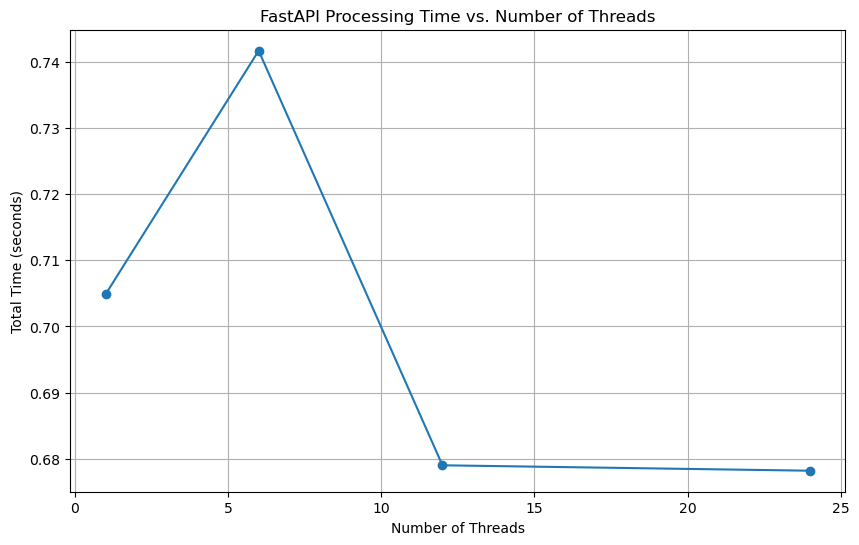

In [2]:
import asyncio
import time
import os
from concurrent.futures import ThreadPoolExecutor
import threading

from fastapi import FastAPI
from pydantic import BaseModel

import httpx
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()  # Allow nested asyncio event loops (required for Jupyter or mixed async environments)

# Initialize the FastAPI app
app = FastAPI()

class DataModel(BaseModel):
    """
    Pydantic model to define the structure of incoming data.

    Attributes:
        data (str): A string containing the data to be processed.
    """
    data: str

@app.post("/process")
async def process(data_model: DataModel):
    """
    FastAPI endpoint that processes incoming data asynchronously.

    Args:
        data_model (DataModel): The input data received via POST request.

    Returns:
        dict: A dictionary containing the processed result.
    
    Note:
        A simulated I/O-bound operation (`await asyncio.sleep(0.1)`) is included
        to mimic real-world scenarios where network or database calls introduce latency.
    """
    await asyncio.sleep(0.1)  # Simulate a delay for I/O-bound operations
    return {"result": f"Processed: {data_model.data}"}  # Return processed result

def run_app():
    """
    Runs the FastAPI server using Uvicorn.

    Note:
        The server is started with `127.0.0.1:12297` as the address and listens
        for incoming HTTP requests. The log level is set to 'warning' to reduce noise.
    """
    import uvicorn
    config = uvicorn.Config(app=app, host="127.0.0.1", port=12297, log_level="warning")
    server = uvicorn.Server(config=config)
    app.state.server = server  # Store the server in FastAPI's state to control it later
    server.run()  # Start the FastAPI app

async def send_requests(num_requests):
    """
    Sends asynchronous HTTP POST requests to the FastAPI server.

    Args:
        num_requests (int): The number of requests to send.

    Returns:
        list: A list of responses received from the FastAPI server.
    
    Note:
        The function uses `httpx.AsyncClient` to send requests concurrently
        and simulates a real-world load by sending a high number of requests.
    """
    limits = httpx.Limits(max_connections=1000, max_keepalive_connections=100)
    async with httpx.AsyncClient(limits=limits) as client:
        tasks = []
        for i in range(num_requests):
            data = {"data": f"Message {i}"}  # Construct the data payload
            tasks.append(client.post("http://127.0.0.1:12297/process", json=data))  # Send POST request
        responses = await asyncio.gather(*tasks)  # Gather all responses asynchronously
    return responses

def benchmark_fastapi(cpu_cores):
    """
    Benchmarks the performance of the FastAPI application using varying thread counts.

    Args:
        cpu_cores (int): The number of CPU cores available on the system.

    Note:
        The function runs the FastAPI server in a separate thread and sends a set number
        of asynchronous HTTP requests to evaluate how different thread counts affect the performance.
    """
    num_requests = 100  # Number of requests to send during each benchmark
    thread_counts = [1, cpu_cores, cpu_cores * 2, min(cpu_cores * 4, 32)]  # Test different thread counts
    results = []

    for threads in thread_counts:
        print(f"\nTesting with {threads} threads.")

        # Update the executor with the current number of threads
        executor = ThreadPoolExecutor(max_workers=threads)
        app.state.executor = executor  # Store the executor in the app state for use by the server

        # Start the FastAPI app in a separate thread
        server_thread = threading.Thread(target=run_app, daemon=True)
        server_thread.start()
        time.sleep(2)  # Give the server time to initialize and start

        # Measure the time taken to process all requests
        start_time = time.time()

        # Create a new event loop and set it as the active loop
        loop = asyncio.new_event_loop()
        asyncio.set_event_loop(loop)
        responses = loop.run_until_complete(send_requests(num_requests))  # Send requests and collect responses

        # Calculate the total time taken for all requests
        total_time = time.time() - start_time
        print(f"Total time for {num_requests} requests: {total_time:.2f} seconds")
        results.append((threads, total_time))  # Store results for plotting

        # Shutdown the server after the benchmark
        app.state.server.should_exit = True
        server_thread.join()

        # Clean up resources
        executor.shutdown(wait=True)
        loop.close()

    # Plot the benchmark results: threads vs time
    thread_counts, times = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.plot(thread_counts, times, marker='o')  # Plot number of threads vs time taken
    plt.title('FastAPI Processing Time vs. Number of Threads')
    plt.xlabel('Number of Threads')
    plt.ylabel('Total Time (seconds)')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    cpu_cores = os.cpu_count()  # Determine the number of CPU cores available on the system
    benchmark_fastapi(cpu_cores)  # Run the benchmarking with varying thread counts
